In [1]:
!pip install sentencepiece
!pip install transformers
!pip install rich[jupyter]
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import os

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

from rich.table import Column, Table
from rich import box
from rich.console import Console


from datasets import load_dataset
cnn_dataset = load_dataset("cnn_dailymail",'3.0.0')
print(type(cnn_dataset['train']))
for i in range(5):
  entry = cnn_dataset['train'][i]
  article = entry['article']
  highlights = entry['highlights']
  id = entry['id']
  print("*"*100)
  print("Article: {}".format(article))
  print("Summary: {}".format(highlights))

  0%|          | 0/3 [00:00<?, ?it/s]

<class 'datasets.arrow_dataset.Dataset'>
****************************************************************************************************
Article: LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, bu

In [3]:
train_dataset, validation_dataset, test_dataset = pd.DataFrame(cnn_dataset["train"][:20000]), pd.DataFrame(cnn_dataset["validation"][:10000]), pd.DataFrame(cnn_dataset["test"][:10000])
train_dataset["article"] = "summarize: " + train_dataset["article"]
validation_dataset["article"]="summarize: " + validation_dataset["article"]
test_dataset["article"]="summarize: " + test_dataset["article"]

In [4]:
train_dataset.shape

(20000, 3)

In [5]:
validation_dataset.shape

(10000, 3)

In [6]:
test_dataset.shape

(10000, 3)

In [7]:

console=Console(record=True)

def display_df(df):
  """display dataframe in ASCII format"""

  console=Console()
  table = Table(Column("source_text", justify="center" ), Column("target_text", justify="center"), title="Sample Data",pad_edge=False, box=box.ASCII)

  for i, row in enumerate(df.values.tolist()):
    table.add_row(row[0], row[1])

  console.print(table)

training_logger = Table(Column("Epoch", justify="center" ), 
                        Column("Steps", justify="center"),
                        Column("Loss", justify="center"), 
                        title="Training Status",pad_edge=False, box=box.ASCII)
training_log_list = []

In [8]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [9]:
class YourDataSetClass(Dataset):
    """
    A custom dataset for reading and loading data into a dataloader for use in finetuning a model.
    """
    def __init__(self, dataframe, tokenizer, source_len, target_len, source_text, target_text):
        """
        Initialize the dataset with the given dataframe, tokenizer, and text column names.
        :param dataframe: a pandas DataFrame containing the data
        :param tokenizer: a tokenizer object to use for encoding text
        :param source_len: the maximum length of source text sequences
        :param target_len: the maximum length of target text sequences
        :param source_text: the name of the column in the dataframe containing source text
        :param target_text: the name of the column in the dataframe containing target text
        """
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.target_len = target_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]

    def __len__(self):
        return len(self.target_text)

    def __getitem__(self, index):
        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # Clean data to ensure it is in string type
        source_text = ' '.join(source_text.split())
        target_text = ' '.join(target_text.split())

        # Encode text and create tensors
        source = self.tokenizer.batch_encode_plus([source_text], max_length=self.source_len,
                                                   pad_to_max_length=True, truncation=True, padding="max_length",
                                                   return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([target_text], max_length=self.target_len,
                                                   pad_to_max_length=True, truncation=True, padding="max_length",
                                                   return_tensors='pt')

        # Extract input and attention masks from encoded text
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        # Return the encoded text and masks as tensors
        return {
            'source_ids': source_ids.to(dtype=torch.long),
            'source_mask': source_mask.to(dtype=torch.long),
            'target_ids': target_ids.to(dtype=torch.long),
            'target_mask': target_mask.to(dtype=torch.long)
        }


In [10]:
def train(epoch, tokenizer, model, device, loader, optimizer):

  """
  Function to be called for training with the parameters passed from main function

  """

  model.train()
  for _,data in enumerate(loader, 0):
    y = data['target_ids'].to(device, dtype = torch.long)
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone().detach()
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
    ids = data['source_ids'].to(device, dtype = torch.long)
    mask = data['source_mask'].to(device, dtype = torch.long)

    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
    loss = outputs[0]
    loss_val = loss.to("cpu").detach().numpy()

    if _%10==0:
      training_logger.add_row(str(epoch), str(_), str(loss_val))
      training_log_list.append([str(epoch), str(_), str(loss_val)])
      console.print(training_logger)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [11]:
def validate(epoch, tokenizer, model, device, loader):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          if _%10==0:
              console.print(f'Completed {_}')

          predictions.extend(preds)
          actuals.extend(target)
  return predictions, actuals

In [17]:
from torchsummary import summary
def T5Trainer(dataframe, source_text, target_text, model_params, output_dir="./outputs/" ):
  
  """
  T5 trainer

  """

  # Set random seeds and deterministic pytorch for reproducibility
  torch.manual_seed(model_params["SEED"]) # pytorch random seed
  np.random.seed(model_params["SEED"]) # numpy random seed
  torch.backends.cudnn.deterministic = True

  # logging
  console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

  # tokenzier for encoding the text
  tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

  # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
  # Further this model is sent to device (GPU/TPU) for using the hardware.
  model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
  model = model.to(device)
  
  # logging
  console.log(f"[Data]: Reading data...\n")

  # Importing the raw dataset
  dataframe = dataframe[[source_text,target_text]]
  display_df(dataframe.head(2))

  
  # Creation of Dataset and Dataloader
  # Defining the train size. So 80% of the data will be used for training and the rest for validation. 
  train_size = 0.8
  train_dataset=dataframe.sample(frac=train_size,random_state = model_params["SEED"])
  val_dataset=dataframe.drop(train_dataset.index).reset_index(drop=True)
  train_dataset = train_dataset.reset_index(drop=True)

  console.print(f"FULL Dataset: {dataframe.shape}")
  console.print(f"TRAIN Dataset: {train_dataset.shape}")
  console.print(f"TEST Dataset: {val_dataset.shape}\n")


  # Creating the Training and Validation dataset for further creation of Dataloader
  training_set = YourDataSetClass(train_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)
  val_set = YourDataSetClass(val_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)


  # Defining the parameters for creation of dataloaders
  train_params = {
      'batch_size': model_params["TRAIN_BATCH_SIZE"],
      'shuffle': True,
      'num_workers': 0
      }


  val_params = {
      'batch_size': model_params["VALID_BATCH_SIZE"],
      'shuffle': False,
      'num_workers': 0
      }


  # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
  training_loader = DataLoader(training_set, **train_params)
  val_loader = DataLoader(val_set, **val_params)


  # Defining the optimizer that will be used to tune the weights of the network in the training session. 
  optimizer = torch.optim.Adam(params =  model.parameters(), lr=model_params["LEARNING_RATE"])


  # Training loop
  console.log(f'[Initiating Fine Tuning]...\n')

  for epoch in range(model_params["TRAIN_EPOCHS"]):
      train(epoch, tokenizer, model, device, training_loader, optimizer)
      
      console.log(f"[Saving Model]...\n")
      #Saving the model after training
      path = os.path.join(output_dir, "model_files")
      model.save_pretrained(path)
      tokenizer.save_pretrained(path)


  # evaluating test dataset
  console.log(f"[Initiating Validation]...\n")
  for epoch in range(model_params["VAL_EPOCHS"]):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
    final_df.to_csv(os.path.join(output_dir,'predictions.csv'))
  
  console.save_text(os.path.join(output_dir,'logs.txt'))
  df_training = pd.DataFrame(training_log_list)
  df_training.to_csv(os.path.join(output_dir,'training_loss.csv'),index=False)
  console.log(f"[Validation Completed.]\n")
  console.print(f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n""")
  console.print(f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n""")
  console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

In [18]:
model_params={
    "MODEL":"t5-base",             # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE":8,          # training batch size
    "VALID_BATCH_SIZE":8,          # validation batch size
    "TRAIN_EPOCHS":10,              # number of training epochs
    "VAL_EPOCHS":1,                # number of validation epochs
    "LEARNING_RATE":1e-4,          # learning rate
    "MAX_SOURCE_TEXT_LENGTH":512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH":50,   # max length of target text
    "SEED": 42                     # set seed for reproducibility 

}

In [19]:
T5Trainer(dataframe=train_dataset[:1000], source_text="article", target_text="highlights", model_params=model_params, output_dir="outputs_1k")

[06:55:50] [Model]: Loading t5-base...                                           <ipython-input-17-2a891a654390>:15
                                                                                                                   

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


[06:55:54] [Data]: Reading data...                                               <ipython-input-17-2a891a654390>:26
                                                                                                                   

                                                    Sample Data                                                    
+-----------------------------------------------------------------------------------------------------------------+
|                      source_text                       |                       target_text                      |
|--------------------------------------------------------+--------------------------------------------------------|
| summarize: LONDON, England (Reuters) -- Harry Potter   | Harry Potter star Daniel Radcliffe gets £20M fortune as|
| star Daniel Radcliffe gains access to a reported £20   |                  he turns 18 Monday .                  |
|   million ($41.1 million) fortune as he turns 18 on    |  Young actor says he has no plans to fritter his cash  |
|Monday, but he insists the money won't cast a spell on  |                         away .                         |
|him. Daniel Radcliffe as Harry Potter in "Harry Potter  | Radcliffe's earnings from first five Potter films have |
|and the Order of the Phoenix" To the disappointment of  |                been held in trust fund .               |
|  gossip columnists around the world, the young actor   |                                                        |
| says he has no plans to fritter his cash away on fast  |                                                        |
|cars, drink and celebrity parties. "I don't plan to be  |                                                        |
|   one of those people who, as soon as they turn 18,    |                                                        |
|suddenly buy themselves a massive sports car collection |                                                        |
|     or something similar," he told an Australian       |                                                        |
|interviewer earlier this month. "I don't think I'll be  |                                                        |
|particularly extravagant. "The things I like buying are |                                                        |
| things that cost about 10 pounds -- books and CDs and  |                                                        |
|  DVDs." At 18, Radcliffe will be able to gamble in a   |                                                        |
|  casino, buy a drink in a pub or see the horror film   |                                                        |
|   "Hostel: Part II," currently six places below his    |                                                        |
|number one movie on the UK box office chart. Details of |                                                        |
| how he'll mark his landmark birthday are under wraps.  |                                                        |
| His agent and publicist had no comment on his plans.   |                                                        |
| "I'll definitely have some sort of party," he said in  |                                                        |
| an interview. "Hopefully none of you will be reading   |                                                        |
|  about it." Radcliffe's earnings from the first five   |                                                        |
| Potter films have been held in a trust fund which he   |                                                        |
| has not been able to touch. Despite his growing fame   |                                                        |
|   and riches, the actor says he is keeping his feet    |                                                        |
|firmly on the ground. "People are always looking to say |                                                        |
|'kid star goes off the rails,'" he told reporters last  |                                                        |
|month. "But I try very hard not to go that way because  |                                                        |
| it would be too easy for them." His latest outing as  

FULL Dataset: (1000, 2)

TRAIN Dataset: (800, 2)

TEST Dataset: (200, 2)

           [Initiating Fine Tuning]...                                           <ipython-input-17-2a891a654390>:75
                                                                                                                   

8.3714


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
+--------------------------+

6.392115
4.9749627
4.9018154
4.292237
3.5280144
3.7280235
3.1562934
3.4128487
3.4837558
2.9067612


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
+--------------------------+

2.9082468
2.9286575
3.1302915
2.8518586
2.8781412
2.4043934
2.9264133
2.7077491
2.97834
2.4709005


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
+--------------------------+

2.4795973
2.7042215
2.6525228
2.499724
2.8269958
2.4801886
2.4456346
2.2846625
2.3531883
1.7827768


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
+--------------------------+

2.4945304
2.6345084
2.331204
2.963339
2.3277714
2.4853077
2.3302402
2.3641036
2.2538369
2.587985


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
+--------------------------+

3.0210905
2.2244594
2.1642957
2.9877338
2.8953342
2.4754798
2.1738296
1.7954031
3.2387562
2.271494


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
+--------------------------+

2.0651112
2.2221522
2.6172774
2.7007496
2.4907863
2.0885072
2.6630058
2.1610749
2.4847004
2.285146


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
+--------------------------+

2.528003
2.576519
2.2635996
2.666548
2.4419227
1.9370161
2.3558679
2.4229748
2.3201413
2.3312988


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
+--------------------------+

2.4350283
2.3238392
2.2648025
2.3353422
2.5400991
2.0766902
2.335012
2.1483011
2.1952674
1.9375895


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
+--------------------------+

2.2556472
2.189584
2.4028394
2.4119914
2.1660786
2.0183663
2.2060676
1.9254767
2.1265268
1.9563111


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
+--------------------------+

2.1256592
1.8926166
2.1462104
2.092483
2.0887694
1.867658
2.3208077
1.8784741
2.0592263


[06:56:26] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

2.1284056


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
+--------------------------+

1.4904292
2.092258
2.080141
2.1934688
1.8579825
2.0700314
1.7492827
2.493345
1.9334105
2.0537379


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
+--------------------------+

2.2332664
1.7697115
2.11679
2.353228
2.1924634
1.7530191
2.3790765
1.8601968
1.7449936
1.6653272


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
+--------------------------+

1.8141644
1.8973546
1.5837127
2.528969
1.5091362
2.1574287
1.6777323
1.9712521
1.9870375
2.1964047


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
+--------------------------+

1.6309278
1.5608811
2.1058037
1.5718191
1.8375593
2.5369692
1.4620849
1.4605844
1.5015054
1.9762655


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
+--------------------------+

1.6857115
1.8454235
1.7972258
2.171863
2.3721657
1.4034638
1.7950532
1.9897405
2.1024554
1.8340964


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
+--------------------------+

1.9318442
2.5529857
1.6009816
1.6486336
1.463414
1.8666539
1.3799008
1.9127355
1.7939034
1.7759483


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
+--------------------------+

1.9519472
2.4660785
2.3660793
1.8599564
1.9808582
1.5491235
1.7155815
2.4599771
1.7421676
1.8307103


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
+--------------------------+

1.5531131
1.7018025
2.001567
1.6717505
2.076029
1.8054935
1.9274986
2.0815036
1.7077179
1.8408812


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
+--------------------------+

1.6389549
1.5669665
1.9902631
2.0900228
1.6188325
2.259518
1.8373252
1.6200148
2.1183023
1.7356012


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
+--------------------------+

2.0321662
2.163491
2.1565506
1.7861351
1.8872049
2.201144
1.9916962
2.3474548
1.6371074


[06:57:00] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

1.5759022


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
+--------------------------+

1.8356665
1.5070641
1.7248143
1.4350301
1.4188849
1.6979123
1.7133653
1.5694236
1.4965107
1.7015787


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
+--------------------------+

1.8284633
1.712482
1.5571849
1.5336375
1.3995454
1.4064047
1.7405084
1.8633909
1.2677205
1.9747741


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
+--------------------------+

1.6741952
1.7869607
2.0908287
2.0508113
1.5310885
1.5203305
1.4947636
1.6484213
1.4343444
1.3468722


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
+--------------------------+

1.7842302
1.3560097
1.399167
1.4791616
1.913999
1.3916719
1.9167844
1.6269685
1.7557784
1.7467929


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
+--------------------------+

2.4581015
1.7144942
1.9043549
1.4895844
1.7660646
1.9101261
1.9060696
1.6739374
1.6309321
1.5749785


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
+--------------------------+

1.7481501
1.5422423
1.4521344
1.5522984
1.4028825
1.5547173
1.327981
1.5828049
1.8212389
1.2393926


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
+--------------------------

1.7990268
1.4423155
1.7119284
1.8398126
1.8861828
1.2658935
1.5813162
1.7705586
1.5900116
1.4977677


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.3464887
1.9801857
1.6899648
1.4303961
1.6069733
2.5310032
1.9786487
1.4230096
1.3740045
1.5085672


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.5921444
1.6077355
2.3275878
1.7033378
1.7278904
1.4406412
1.668404
1.2674886
1.7885398
1.3645355


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.4779027
1.4705126
1.673296
1.318803
1.6639689
1.9389144
1.6381941
1.6846259
1.4298493


[06:57:35] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

1.4157721


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.2293271
1.6336094
1.2806579
1.5114152
1.5603708
1.2060952
1.4943247
1.5405262
1.1340948
1.2799007


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.4510264
1.4230217
1.8112407
1.5018114
1.6651495
1.3457578
1.4989038
1.4059982
1.6627218
1.6432796


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.680709
1.3598821
1.6763572
1.4098747
1.2662467
1.2748154
1.5359321
1.5893606
1.3708037
1.5911307


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.5690767
1.5679342
1.7295493
1.5261638
1.7104505
1.499737
1.2077682
1.5728515
1.2108186
1.2212677


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.4088241
1.1338217
1.2871174
1.2799445
1.5429865
1.3209592
1.7923281
1.3475723
0.95903885
1.434084


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.4384413
0.9379653
1.2101039
1.43554
1.5550017
1.3747668
1.7288637
1.3191267
1.6799265
1.3831135


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.5953282
1.3889959
1.513614
1.1628631
1.3651252
1.4334357
1.5457768
1.4582962
1.3260736
1.3306453


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.8061224
1.6522639
1.6132013
1.4377285
0.8489937
1.1350626
1.5674216
1.4071414
1.7998571
1.3352836


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.1137736
1.4588898
1.5011673
1.6009563
1.3934622
1.6732974
1.1172969
1.3595314
1.49239
1.2446622


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.5646446
1.4939011
1.4105109
1.4587615
1.5541812
1.370359
1.3257421
1.486472
1.2535521


[06:58:09] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

1.233496


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.209279
1.1013823
1.0943779
1.2011428
0.7432031
1.2264761
1.2759751
1.1581025
1.2861811
1.2626945


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.1168145
1.6662965
1.2245406
1.3599033
1.2361478
1.1749752
1.2083365
1.0197895
1.1092149
1.5467751


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.95905524
1.2601751
1.2913187
1.3857995
1.1217096
1.0188042
1.144632
1.2829297
1.5749111
1.4807189


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.4148337
0.9147606
1.1893435
1.2525437
1.2506155
0.99562746
1.074514
1.2026331
1.6419208
1.1756836


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.3083605
1.1936036
1.0732335
1.540495
1.6568738
1.3436604
1.1983409
1.6177197
1.6153402
1.4910796


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.6244682
1.4443848
1.0747992
1.3070339
1.4087209
1.0961145
1.0320687
1.2577834
1.455045
1.5842334


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.6328888
1.4413109
1.0789994
1.0839328
1.4315083
1.3011304
1.0234189
1.3900732
1.2228973
1.0078552


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.2770373
1.2941434
1.2468252
1.2613145
1.0811527
1.6145474
1.814351
1.3296957
1.784073
1.467414


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0199519
1.0763147
0.8632101
0.92653143
1.09449
0.8785623
0.94177216
1.6222022
1.093468
1.3685057


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.1470109
1.0584531
1.2131563
1.6107264
1.1940651
0.96523136
1.0777534
1.460659
1.1769016


[06:58:43] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

0.928363


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.3436557
1.1634606
0.9542487
1.1346439
1.2438282
1.0289708
1.319434
1.4149402
1.122406
1.0893615


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.9202932
1.4346714
1.0045025
1.1371583
1.0717931
1.1818057
0.98908633
1.0240177
1.354742
1.0670139


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.2965324
1.1654141
0.9576001
0.95363075
0.9917738
0.9577978
0.86318666
0.8839914
1.1981754
1.2152783


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.042604
1.0317109
1.0453895
1.0925512
1.0454984
1.1575657
1.0853647
1.2494956
0.8697171
1.4454994


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0718019
1.2913085
1.1307935
0.9543548
0.9914304
1.1490147
1.1945583
1.1586698
1.1415087
0.7818867


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0291884
1.3232592
1.1195881
1.1689087
1.1242571
0.93908834
1.4474725
1.3188561
1.2350377
0.96748793


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0383888
0.7823754
1.1745622
1.2679662
1.6823363
1.2434802
0.84733015
0.9742408
0.8554275
0.87054634


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0711843
0.93166786
1.02134
1.1961844
1.1501793
1.3445327
1.2792267
0.9634675
1.1181476
1.1705823


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.2267454
0.9660298
0.9974982
1.2715389
1.1066477
1.4221395
0.68123084
1.0162239
1.0698214
1.1423616


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0398898
1.0548087
0.8441228
0.778679
1.2360891
1.3850803
1.0585865
1.1895106
1.229651


[06:59:17] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

1.1475638


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.9543126
1.2984334
0.8892618
0.98471504
0.94713444
0.9886815
1.0412437
1.0535169
0.97048783
0.97832817


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.78299487
1.046582
1.0424923
1.0947969
1.0286938
0.9820547
0.7230646
1.0083941
0.75048065
0.81624484


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.99998707
1.036826
0.75465655
0.9466247
1.006038
0.53742176
0.9949174
1.0569386
1.2044815
0.9952064


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0150511
0.7084174
0.9192817
0.9519148
0.95751536
0.63115054
0.85688764
1.1468122
1.0185777
0.94050443


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.7869393
0.9518819
0.9751091
0.8572253
1.1365644
0.77378887
1.3127232
0.72647303
1.2185093
1.1228197


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.8738292
1.2416323
1.1356953
0.7524926
1.3141586
1.1820203
1.0215722
0.9691445
0.9772968
0.9186192


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.91634154
0.79448986
1.0548794
1.2215999
1.0797378
1.0250747
1.3321972
1.1494824
0.8548935
0.8760523


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0469409
1.0574508
0.8759598
0.98786265
1.027499
0.948929
0.81749105
0.86355615
1.1729382
0.84438306


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.94135493
0.8840862
0.97002035
1.1875492
0.84418964
0.9155756
0.94751894
0.89287823
1.3770657
0.9621111


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.9259331
0.92429835
0.8743797
1.2181927
0.9453292
1.1284219
1.1096574
0.7899527
1.1017305


[06:59:51] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

0.93672085


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.8984122
0.9533636
0.8858483
1.1729709
0.65465385
0.8520336
0.8996764
0.88314134
0.9653953
0.9363139


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.8233309
0.7397905
0.5649595
1.0900664
0.6929824
0.7736488
1.0680684
0.6501997
0.5846701
0.7101406


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.2462884
0.59595436
0.8705072
0.61872923
1.0604392
0.78386194
0.8361783
0.60739356
1.1901131
0.7918535


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.7313288
0.71605104
0.61328006
1.22727
0.84065044
0.91970783
0.7586185
1.072767
0.85453004
0.68584263


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.177497
0.65358645
0.8151968
0.8579733
0.9850731
0.74220043
0.77314574
0.8884751
0.94998
1.0360576


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.88344806
0.8575022
0.68309367
0.81999063
0.7622284
0.88139254
1.0663588
0.781942
1.0070436
0.8680752


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.8053661
0.72591376
0.66770816
0.60816866
0.7701447
0.69744164
0.9082018
0.6971976
0.83957636
0.8945958


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.0617294
1.1478925
0.65439713
0.9855207
0.9876772
0.78063095
0.95847094
0.9985714
1.2378165
0.9399876


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.8869456
1.0320114
0.94590825
0.7826686
0.87486875
1.0878679
1.0160228
0.9902341
0.6559605
1.1589918


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

1.1846131
0.6620219
1.15808
0.9210075
0.89917505
0.8215659
0.7588895
1.1794407
1.006812


[07:00:26] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

0.81903386


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.6094878
0.6079546
0.781474
0.8212843
1.0886394
0.68861413
0.73176134
0.8789133
0.69192296
0.8101184


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.64737207
0.6758433
0.9564388
0.7889147
0.73979896
0.7314151
0.9067203
1.1004416
0.63201743
0.5080218


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.94234663
0.5485292
0.7566572
0.68981016
0.57229984
0.66515577
1.0577767
0.8457694
0.78849375
0.67453986


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.73010033
0.89039254
0.8305882
0.7369954
1.0297679
0.6082341
0.7183777
0.87433666
0.8149336
0.58370805


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.97109663
0.7590464
0.91061527
0.7223655
0.72786474
1.0369612
0.47041774
0.64906776
0.66734076
0.7437257


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.80674225
0.84549016
0.5822201
0.96619743
0.6694614
0.7232959
1.0975634
0.7859549
0.9593273
0.6489144


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.77712363
0.5948853
0.89608145
0.7299436
0.7595509
0.53438085
0.7022339
1.0318782
0.56726736
0.76654977


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.83912575
0.72925264
1.0190399
0.7821458
0.79538894
0.95133704
0.9007981
0.92774093
0.88835657
0.8468976


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.9949349
0.98926014
0.93125576
0.78986824
0.7427044
0.5463587
0.39565822
0.77775365
1.0143629
0.6788466


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.6506914
0.6855707
0.6882853
0.8207324
0.8834276
0.73636585
0.59852237
0.9784135
0.68566847


[07:01:00] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

0.6830613


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.6436907
0.58801764
0.6126259
0.7161501
0.6172828
0.6090988
0.6732822
0.66166914
0.41669157
0.44302166


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.5476388
0.841407
0.546288
0.5788087
0.67273015
0.74896455
0.67484576
0.79773146
0.6485396
0.8940022


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.61524564
0.5706182
0.7556372
0.54886174
0.5855335
0.62762004
0.6964427
0.7346117
0.61093736
0.75940514


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.8623591
0.68587226
0.59528786
0.45909372
0.81380415
0.7195637
0.75860643
0.68056816
0.6184445
0.6298734


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.3621394
0.548471
0.57966787
0.54762447
0.7506573
0.971669
0.5877293
0.50568396
0.68269235
0.57430094


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.7517608
0.76620847
0.72515804
1.0414551
0.6650358
1.0159874
0.91683793
0.7729034
0.6147408
0.52183527


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.9766976
0.9507611
0.48396912
0.59238076
0.8008006
0.633675
0.7209277
0.8645755
0.5597071
0.7032039


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.7075581
0.77349436
1.0638285
0.6504353
0.52702904
0.6497085
0.4820465
0.8273911
0.56728786
0.6431849


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.6039338
0.6367051
0.7841588
0.5651135
0.92975074
0.75597984
0.844728
0.8000427
0.6277592
0.72065175


      Training Status       
+--------------------------+
|Epoch | Steps |    Loss   |
|------+-------+-----------|
|  0   |   0   |  6.975604 |
|  1   |   0   |  3.820239 |
|  2   |   0   |  2.586929 |
|  3   |   0   | 1.8692255 |
|  4   |   0   | 1.5503778 |
|  5   |   0   | 1.2255064 |
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 |
|  2   |  80   | 1.5085672 |
|  2   |  90   | 1.3645355 |
|  3   |   0   | 1.4157721 |
|  3   |  10   | 1.2799007 |
|  3   |  20   | 1.6432796 |
|  3   |  30   | 1.5911307 |
|  3   |  40   | 1.2212677 |
|  3   |  50   |  1.434084 |
|  3   |  60   | 1.3831135 |
|  3   |  70   | 1.3306453 |
|  3   |  80   | 1.3352836 |
|  3   |  90   | 1.2446622 |
|  4   |   0   |  1.233496 |
|  4   |  10   | 1.2626945 |
|  4   |  20   | 1.5467751 |
|  4   |  30   | 1.4807189 |
|  4   |  40   | 1.1756836 |
|  4   |  50   | 1.4910796 |
|  4   |  60   | 1.5842334 |
|  4   |  70   | 1.0078552 |
|  4   |  80   |  1.467414 |
|  4   |  90   | 1.3685057 |
|  5   |   0   |  0.928363 |
|  5   |  10   | 1.0893615 |
|  5   |  20   | 1.0670139 |
|  5   |  30   | 1.2152783 |
|  5   |  40   | 1.4454994 |
|  5   |  50   | 0.7818867 |
|  5   |  60   | 0.96748793|
|  5   |  70   | 0.87054634|
|  5   |  80   | 1.1705823 |
|  5   |  90   | 1.1423616 |
|  6   |   0   | 1.1475638 |
|  6   |  10   | 0.97832817|
|  6   |  20   | 0.81624484|
|  6   |  30   | 0.9952064 |
|  6   |  40   | 0.94050443|
|  6   |  50   | 1.1228197 |
|  6   |  60   | 0.9186192 |
|  6   |  70   | 0.8760523 |
|  6   |  80   | 0.84438306|
|  6   |  90   | 0.9621111 |
|  7   |   0   | 0.93672085|
|  7   |  10   | 0.9363139 |
|  7   |  20   | 0.7101406 |
|  7   |  30   | 0.7918535 |
|  7   |  40   | 0.68584263|
|  7   |  50   | 1.0360576 |
|  7   |  60   | 0.8680752 |
|  7   |  70   | 0.8945958 |
|  7   |  80   | 0.9399876 |
|  7   |  90   | 1.1589918 |
|  8   |   0   | 0.81903386|
|  8   |  10   | 0.8101184 |
|  8   |  20   | 0.5080218 |
|  8   |  30   | 0.67453986|
|  8   |  40   | 0.58370805|
|  8   |  50   | 0.7437257 |
|  8   |  60   | 0.6489144 |
|  8   |  70   | 0.76654977|
|  8   |  80   | 0.8468976 |
|  8   |  90   | 0.6788466 |
|  9   |   0   | 0.6830613 |
|  9   |  10   | 0.44302166|
|  9   |  20   | 0.8940022 |
|  9   |  30   | 0.75940514|
|  9   |  40   | 0.6298734 |
|  9   |  50   | 0.57430094|
|  9   |  60   | 0.52183527|
|  9   |  70   | 0.7032039 |
|  9   |  80   | 0.6431849 |
|  9   |  90   | 0.72065175|
|  0   |   0   |   8.3714  |
|  0   |  10   | 2.9067612 |
|  0   |  20   | 2.4709005 |
|  0   |  30   | 1.7827768 |
|  0   |  40   |  2.587985 |
|  0   |  50   |  2.271494 |
|  0   |  60   |  2.285146 |
|  0   |  70   | 2.3312988 |
|  0   |  80   | 1.9375895 |
|  0   |  90   | 1.9563111 |
|  1   |   0   | 2.1284056 |
|  1   |  10   | 2.0537379 |
|  1   |  20   | 1.6653272 |
|  1   |  30   | 2.1964047 |
|  1   |  40   | 1.9762655 |
|  1   |  50   | 1.8340964 |
|  1   |  60   | 1.7759483 |
|  1   |  70   | 1.8307103 |
|  1   |  80   | 1.8408812 |
|  1   |  90   | 1.7356012 |
|  2   |   0   | 1.5759022 |
|  2   |  10   | 1.7015787 |
|  2   |  20   | 1.9747741 |
|  2   |  30   | 1.3468722 |
|  2   |  40   | 1.7467929 |
|  2   |  50   | 1.5749785 |
|  2   |  60   | 1.2393926 |
|  2   |  70   | 1.4977677 

0.73595136
0.57183594
0.54968405
0.73431337
0.5598977
0.68928087
0.66677314
0.7902407
0.5639097


[07:01:35] [Saving Model]...                                                     <ipython-input-17-2a891a654390>:80
                                                                                                                   

[07:01:37] [Initiating Validation]...                                            <ipython-input-17-2a891a654390>:88
                                                                                                                   

Completed 0

Completed 10

Completed 20

[07:02:40] [Validation Completed.]                                               <ipython-input-17-2a891a654390>:97
                                                                                                                   

[Model] Model saved @ outputs_1k/model_files

[Validation] Generation on Validation data saved @ outputs_1k/predictions.csv

[Logs] Logs saved @ outputs_1k/logs.txt

In [ ]:
pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from rouge import Rouge
def calculate_rouge(summaries, references):
    rouge_calculator = Rouge()
    scores = rouge_calculator.get_scores(summaries, references, avg=True)
    rouge_score = scores
    return rouge_score

In [ ]:
import pandas as pd
results = pd.read_csv("outputs_50k/predictions.csv") 

In [ ]:
results

,Unnamed: 0,Generated Text,Actual Text
0,0,"""I probably had a 30-, 35-foot free fall,"" sur...","NEW: ""I thought I was going to die,"" driver sa..."
1,1,The 20-year-old AT4 anti-tank rocket launcher ...,Empty anti-tank weapon turns up in front of Ne...
2,2,"Bush to tell veterans of foreign war: ""The rea...",President Bush to address the Veterans of Fore...
3,3,Brazilian striker Carlos Alberto joins Werder ...,Werder Bremen pay a club record $10.7 million ...
4,4,"At least 14 people killed, 60 wounded in attac...",Bomb victims waiting for presidential visit. B...
...,...,...,...
9995,9995,"""The Artist"" wins best picture at the Academy ...","""The Artist"" won Academy Awards for best pictu..."
9996,9996,Japan authorizes passenger airlines to resume ...,The Japanese decision follows a directive from...
9997,9997,The suspect is found dead in the home where th...,"A stepson says the man shot his mother, brothe..."
9998,9998,The largest arts festival in the world takes o...,The biggest arts festival in the world runs fr...


In [ ]:
calculate_rouge(results['Generated Text'],results['Actual Text'])

{'rouge-1': {'r': 0.312939217820227,
  'p': 0.3189673267262811,
  'f': 0.3140002773296394},
 'rouge-2': {'r': 0.129562148475484,
  'p': 0.1344849930441197,
  'f': 0.13107645946134913},
 'rouge-l': {'r': 0.2962789639659446,
  'p': 0.3020669702490252,
  'f': 0.2973143742401938}}

In [21]:
results = pd.read_csv("outputs_1k/predictions.csv") 

In [22]:
calculate_rouge(results['Generated Text'],results['Actual Text'])

{'rouge-1': {'r': 0.3564727090259656,
  'p': 0.31347096170901473,
  'f': 0.33004471952188885},
 'rouge-2': {'r': 0.14992395678160983,
  'p': 0.13303237960898412,
  'f': 0.1393033442364946},
 'rouge-l': {'r': 0.3390825352200554,
  'p': 0.29847517713729504,
  'f': 0.3140725059018317}}

In [42]:
df = pd.read_csv("/content/outputs_50k/training_loss.csv",index_col=False)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.columns = ['epoch',"step","loss"]
df.drop(["step"],axis=1,inplace=True)
data = []
i = 1
for index,row in df.iterrows():
  if i % 500 == 0:
    print(i)
    data.append(row['loss'])
  i+=1
df = pd.DataFrame(data)

500
1000
1500


Model : T5 for Text Summarization
Dataset Size: 50K


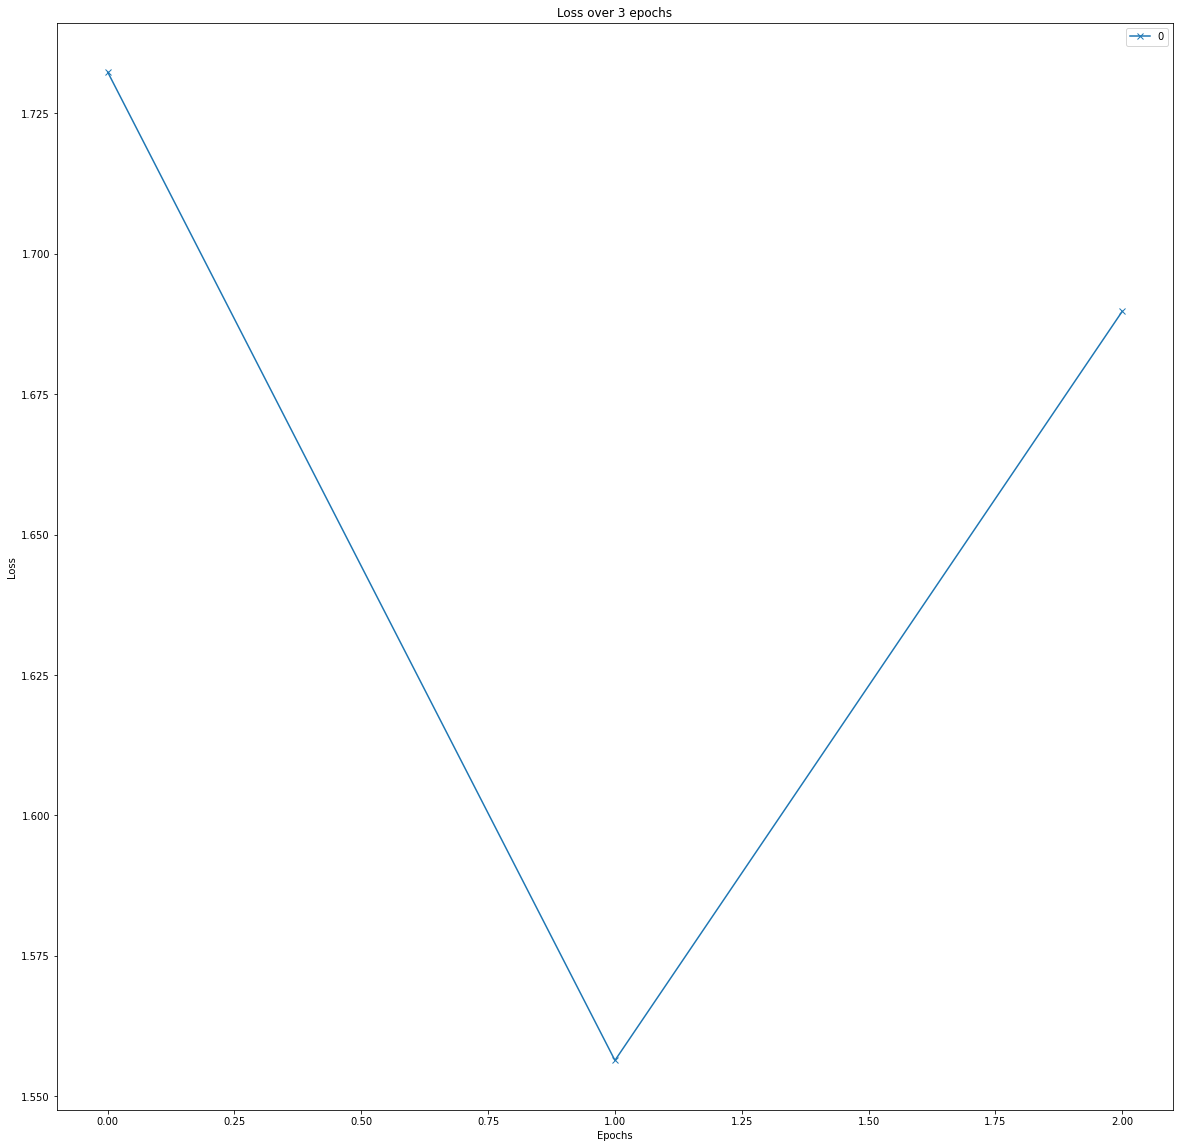

In [43]:
import matplotlib.pyplot as plt
ax = df.plot(figsize=(20,20),kind='line',marker='x')
ax.set_title("Loss over 3 epochs") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
print("Model : T5 for Text Summarization\nDataset Size: 50K")
ax.get_figure().savefig('epoch_vs_loss_50k.png')


In [ ]:
df = pd.read_csv("/content/outputs_20k/training_loss.csv",index_col=False)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.columns = ['epoch',"step","loss"]
df.drop(["step"],axis=1,inplace=True)
# data = []
# i = 1
# for index,row in df.iterrows():
#   if i % 500 == 0:
#     print(i)
#     data.append(row['loss'])
#   i+=1
# df = pd.DataFrame(data)

FileNotFoundError: ignored